# Final Project: Building a daily life assistant with an Instruction-Fine-Tuned GPT-2

Paul CASCARINO E5DSIA 2025 - ESIEE PARIS 


# 0. Introduction

I was interested in working on a virtual assistant that could serve as a solid foundation for real-world projects. Therefore, I decided to focus on bots for online websites. I came across the Customer_Support_Training_Dataset_27k dataset on Kaggle: https://www.kaggle.com/datasets/divyanshu2000/customer-support-training-dataset-27k, which includes:

- Instructions
- Responses
- Categories associated with the responses
- Actions to take


Initially, I thought that in addition to building a basic instruction/response virtual assistant, I could enhance it with a fine-tuned LLM for classification tasks. This way, it could both respond to instructions and meet the requirements of this assignment, while also opening the door for further fine-tuning of the LLM. I could apply what I learned from lab 6.

However, I encountered a computer capacity issue throughout this project, which limited the time I could dedicate to this dual project. As a result, I had to focus on just reducing the model training more and more, while waiting for the crash after long computation times...


# 1. Environment Setup & Base Model Initialization

## 1.0 Setup

In [1]:
import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt


import tiktoken

import tensorflow as tf
import torch
from torch.utils.data import Dataset, DataLoader

from gpt_download import download_and_load_gpt2
from previous_labs import GPTModel, load_weights_into_gpt


df = pd.read_csv('Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv')


## 1.1 Loading a pretrained LLM

We will use GPT-2 S because for same reason than all this work, my laptop.

In [2]:
BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


# 2. Instruction Dataset Preparation

## 2.1 Basic dataset analysis

I focus on this part to understand more my dataset and prepare it for my dual project to add a LLM trained for classification of one of the 2 categories that I cite in this part.

In [3]:
df = df.drop(columns=['flags'])

df = df[['instruction', 'response', 'category', 'intent']]

df = df.sample(frac=0.05, random_state=123).reset_index(drop=True)
df.head()

,instruction,response,category,intent
0,help speaking with a human agent,Thank you for contacting! I certainly recogniz...,CONTACT,contact_human_agent
1,find information about the removal of my pro a...,Glad you contacted to us to inquire about the ...,ACCOUNT,delete_account
2,I'm unhzppy with ur work make a reclamation,I'm truly sorry to hear that you're unhappy wi...,FEEDBACK,complaint
3,switching to pro account,I'm happy to help! I can assist you in seamles...,ACCOUNT,switch_account
4,reimburse {{Currency Symbol}}{{Refund Amount}},"I've understood, you are seeking a reimburseme...",REFUND,get_refund


In [4]:
df

,instruction,response,category,intent
0,help speaking with a human agent,Thank you for contacting! I certainly recogniz...,CONTACT,contact_human_agent
1,find information about the removal of my pro a...,Glad you contacted to us to inquire about the ...,ACCOUNT,delete_account
2,I'm unhzppy with ur work make a reclamation,I'm truly sorry to hear that you're unhappy wi...,FEEDBACK,complaint
3,switching to pro account,I'm happy to help! I can assist you in seamles...,ACCOUNT,switch_account
4,reimburse {{Currency Symbol}}{{Refund Amount}},"I've understood, you are seeking a reimburseme...",REFUND,get_refund
...,...,...,...,...
1339,"I have got to submit the new shipping address,...",I'm conscious of the reality that you're looki...,SHIPPING,set_up_shipping_address
1340,i have to locate the invoice #00108,Of course! I understand your need to locate th...,INVOICE,check_invoice
1341,I have to know if there is anything wrong with...,I understand your need to know if there is any...,REFUND,track_refund
1342,would it be possible to see what shipping opti...,Thank you for your inquiry about our shipping ...,DELIVERY,delivery_options


Number of null values for instructions: 0


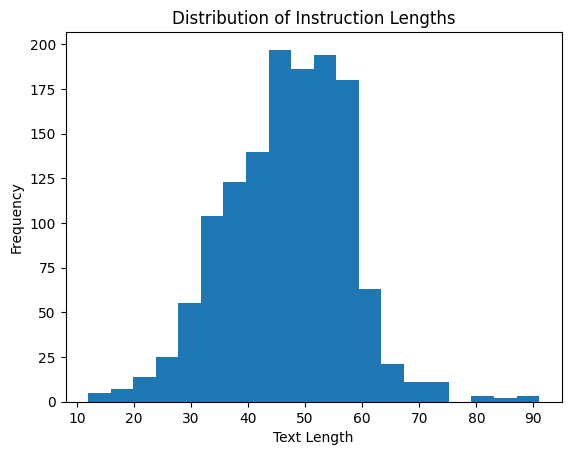

In [5]:
# Count non-null values
print(f"Number of null values for instructions: {df['instruction'].isnull().sum()}")

# Add a new column for text length
df['instruction_length'] = df['instruction'].str.len()

df['instruction_length'].plot(kind='hist', bins=20, title='Distribution of Instruction Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


Number of null values for response: 0


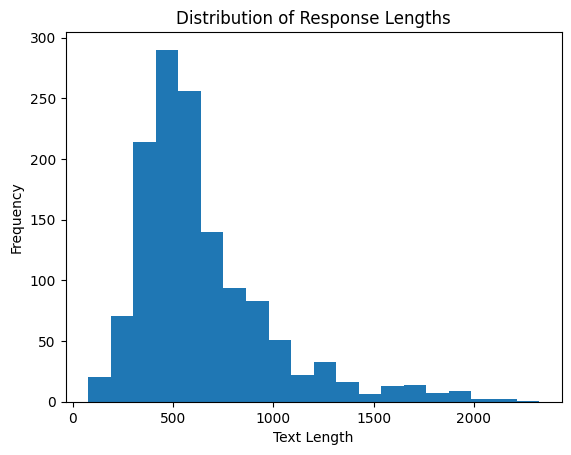

In [6]:
# Count non-null values
print(f"Number of null values for response: {df['response'].isnull().sum()}")

# Add a new column for text length
df['response_length'] = df['response'].str.len()

df['response_length'].plot(kind='hist', bins=20, title='Distribution of Response Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

We can see that there are no NA or NULL values for our instruction and response values, which is a positive aspect.

The count plot representing the length of the instruction and response values demonstrates that there are none, or very few, excessively long messages.

The dataset is tidy!

## 2.2 Dataset analysis for bonus

We will look categorical columns : 

- category
- intent

to permit our method to response to our customer AND treat the demand automatically



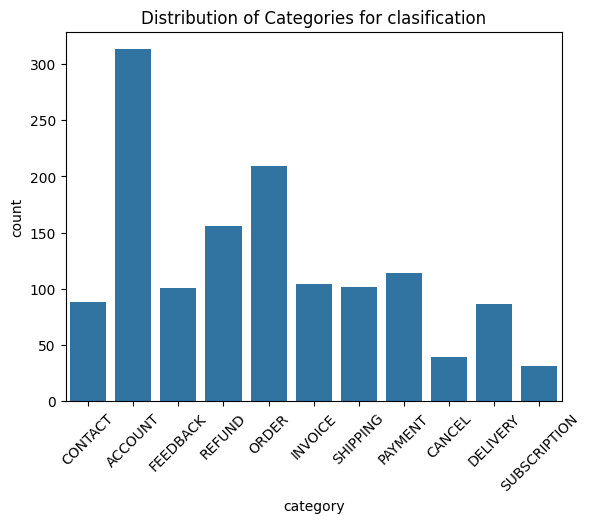

In [7]:
sns.countplot(data=df, x='category')
plt.title('Distribution of Categories for clasification')
plt.xticks(rotation=45) 
plt.show()

We can see that the repartition of different categories is unbalanced. I think the most important things is not the category of the demand but the action to do. We have them with the column *intent*

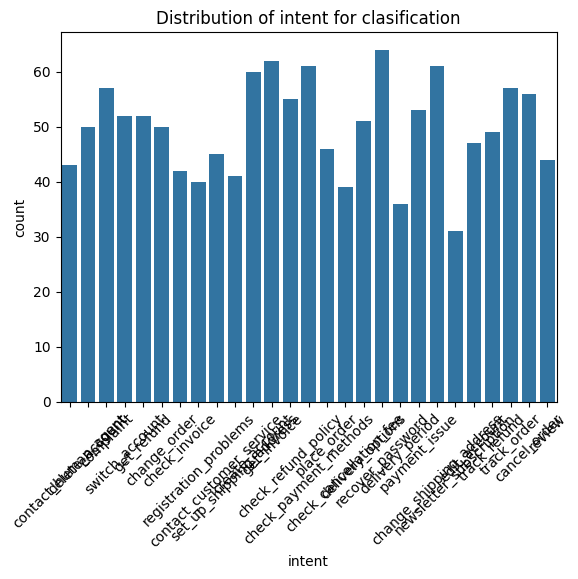

In [8]:
sns.countplot(data=df, x='intent')
plt.title('Distribution of intent for clasification')
plt.xticks(rotation=45) 
plt.show()

We can see that the distribution of different categories is balanced! Therefore, we do not need to use the function created in Lab 6: create_balanced_dataset for our bonus.

Unfortunately, as I said before, I will not work on that but I let that to show that I tried. If it will works i will choose to a LLM trained for classify the intent, the uniform categorical. An idea is to map teh categorie into numbers (below)

## 2.3 Dataset preparation

In [9]:
df = df.drop(columns=['category', 'instruction_length',	'response_length'])


df['intent_mapped'] = pd.Categorical(df['intent']).codes


df.head()

,instruction,response,intent,intent_mapped
0,help speaking with a human agent,Thank you for contacting! I certainly recogniz...,contact_human_agent,9
1,find information about the removal of my pro a...,Glad you contacted to us to inquire about the ...,delete_account,11
2,I'm unhzppy with ur work make a reclamation,I'm truly sorry to hear that you're unhappy wi...,complaint,7
3,switching to pro account,I'm happy to help! I can assist you in seamles...,switch_account,24
4,reimburse {{Currency Symbol}}{{Refund Amount}},"I've understood, you are seeking a reimburseme...",get_refund,16


### 2.3.1 train/test/val
Let's now define a function that randomly divides the dataset into training, validation, and test subsets.
We will split in train/test/val with 70%/20%/10%

In [10]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(df, 0.7, 0.1)

# train_df.to_csv("train.csv", index=None)
# validation_df.to_csv("validation.csv", index=None)
# test_df.to_csv("test.csv", index=None)

### 2.3.2 - Alpaca-style 
We use Alpaca-style prompt formatting, which was the original prompt template for instruction finetuning.

We will formating directly using our dataframe

In [11]:
def df_to_data(df):
    # Initialize the list that will store the resulting dictionaries
    result = []

    # Iterate over each row in the dataframe
    for _, row in df.iterrows():
        # Create a dictionary for each row, formatted as required
        result.append({
            'instruction': f'Write a response to the following: {row["instruction"]}',
            'input': row['response'],
            'output': f'The response for this instruction is: {row["response"]}'
        })
    
    return result


train_data = df_to_data(train_df)
val_data = df_to_data(validation_df)
test_data = df_to_data(test_df)

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 940
Validation set length: 134
Test set length: 270


### 2.3.3 - Organizing data into training batches

We create an *InstructionDataset* class that pre-tokens all the inputs in the dataset.

In [12]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if 'input' in entry and entry["input"] else ""

    return instruction_text + input_text

model_input = format_input(df.iloc[1])
desired_response = f"\n\n### Response:\n{df['response'][1]}"

print(model_input + desired_response)


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
find information about the removal of my pro account

### Response:
Glad you contacted to us to inquire about the removal of your {{Account Type}} account. We understand that you may have questions and concerns regarding the cancellation process, and we're here to assist you. To find detailed information about removing your {{Account Type}} account, I recommend visiting our website and navigating to the account settings or FAQ section. If you need specific assistance or have further questions, please don't hesitate to let us know. We're committed to ensuring a seamless experience for you throughout the entire account removal process.


Instead of manually padding all examples in the dataset, we create a custom "collate" function. This function is passed to the data loader and automatically handles padding within each batch. It ensures that the examples in each batch have the same length, but batches themselves can have different lengths. This approach is more flexible and efficient, especially when working with varying input sizes.

The custom collate_fn function enhances the padding process by handling it dynamically for each batch. It first determines the longest sequence in the batch, then pads all sequences to match this length by adding a padding token (pad_token_id). The function also creates two tensors, one for inputs and another for targets: the inputs are truncated by one token, while the targets are shifted by one token to the right. Additionally, it introduces two new features:

- It replaces padding tokens in the targets (except for the first one) with ignore_index to avoid loss in padding areas.
  
- It allows truncation to a maximum sequence length (allowed_max_length) if specified.
  
This method ensures that each batch has padded sequences of equal length, while still allowing different batches to have varying lengths and providing additional control over the padding and truncation behavior.

In [13]:
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))



def customized_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor



[50256]


Another Idea but I can't compute it for same reason is to add a special tokens for the values found in our dataframe : 

- {{Currency Symbol}}
- {{Refund Amount}}
- ...

The amount is not important but this is one point I would like to focus if...

### 2.3.4 - Creating data loaders for an instruction dataset

In [14]:
num_workers = 0
batch_size = 5

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [15]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([5, 444]) torch.Size([5, 444])
torch.Size([5, 512]) torch.Size([5, 512])
torch.Size([5, 439]) torch.Size([5, 439])
torch.Size([5, 452]) torch.Size([5, 452])
torch.Size([5, 477]) torch.Size([5, 477])
torch.Size([5, 835]) torch.Size([5, 835])
torch.Size([5, 320]) torch.Size([5, 320])
torch.Size([5, 581]) torch.Size([5, 581])
torch.Size([5, 316]) torch.Size([5, 316])
torch.Size([5, 767]) torch.Size([5, 767])
torch.Size([5, 392]) torch.Size([5, 392])
torch.Size([5, 549]) torch.Size([5, 549])
torch.Size([5, 835]) torch.Size([5, 835])
torch.Size([5, 802]) torch.Size([5, 802])
torch.Size([5, 502]) torch.Size([5, 502])
torch.Size([5, 330]) torch.Size([5, 330])
torch.Size([5, 368]) torch.Size([5, 368])
torch.Size([5, 694]) torch.Size([5, 694])
torch.Size([5, 764]) torch.Size([5, 764])
torch.Size([5, 494]) torch.Size([5, 494])
torch.Size([5, 472]) torch.Size([5, 472])
torch.Size([5, 430]) torch.Size([5, 430])
torch.Size([5, 372]) torch.Size([5, 372])
torch.Size([5, 795])

We can see that the dimensions of the resulting input look like the target batches.

All batches have a size of 5 (reduce complexity of the model) and a different length.

In [16]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 16594,   257,  2882,   284,   262,  1708,
           25,  1312,   423,  1278,    83,   284,  3328,   262, 13129,  1037,
          502,   198,   198, 21017, 23412,    25,   198,    40,  1101,  7926,
          284,  3285,   326,   345,  4398,   470,   587,  6464,   262, 13129,
          355,  2938,    13,  3914,   502,  3342,   345,   287, 31038,   428,
         2071,   290,  4155,   326,   345,   923,  6464,   674,  8119,  2695,
        19268,    13,  1675,  3342,   345,  2252,    11,   714,   345,  3387,
         2148,   502,   351,   262,  3053,  2209,   345,   973,   284, 12383,
           30,   314,  1183,  9161,   262,  2300,  3393,   290,  1011,   262,
         3306,  4831,   284, 13621,  1958,   262,  3074,    13,  3406, 14676,
          318,   674, 27878,  8475,    11,   290,   314,  9144, 

We can see all our 50256  representing <|endoftext|> padding token.

# 3. Instruction Fine-Tuning

Let's test our model before the fine tuning

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(123)


input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Write a response to the following: ya have a method to send a comment about a product

### Input:
Thank you for your interest in providing feedback on our product. We have a dedicated system in place to receive comments and suggestions from our valued customers like yourself. You can send your comment about the product by visiting our website and navigating to the "Contact Us" or "Feedback" page. There, you will find a form where you can write your comments and submit them directly to our team. We greatly appreciate your input as it helps us improve the quality of our products and services. If you need any further assistance or have any other questions, please do not hesitate to let me know.


In [18]:
from previous_labs import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [19]:
from previous_labs import (
    calc_loss_loader,
    train_model_simple
)


model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 1.9643784761428833
Validation loss: 1.9019601345062256


We can see that the pre-trained model hasa training and a validation cost at arround 1.9 wich is not horrible without the fine-tuning. 

In [20]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

# train_losses, val_losses, tokens_seen = train_model_simple(
#     model, train_loader, val_loader, optimizer, device,
#     num_epochs=num_epochs, eval_freq=50, eval_iter=5,
#     start_context=format_input(val_data[0]), tokenizer=tokenizer
# )

# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

In [21]:
state_dict = torch.load("model_save.pth", weights_only=True)  
model.load_state_dict(state_dict)

model.eval();

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)



Training loss: 0.5786167502403259
Validation loss: 0.6012560427188873


I has see (not in entire), (I really hope I can make it turn more than 2 frequencies before sending) but the models trains really well, the training and validation loss starts around at 1.5-1.9 and decrease to 0.7-0.9 then decrease to 0.5 then I don't know...

**BUT I want to save a little bit my work and say that because my model is not complexe, has few parameters and few epochs, I have less risk to overfit than other models but it can happens.
My model is probably underfit and my response will probably seems to the pre-trained model that I used.**



MIRACLE ! It turns on my old computer !!! We can see that :

- the model BEFORE the training : 
  - Training loss: 1.9643784761428833
  - Validation loss: 1.9019601345062256

- the model AFTER the training : 
  - Training loss: 0.5786167502403259
  - Validation loss: 0.6012560427188873

We have a significant amelioration our training works ! (probably not at his maximum but in my situation I am saves !)

# 4. Evaluation & Iterative Improvement

In [23]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Write a response to the following: updating info on premium account

### Input:
How fantastic it is to witness your enthusiasm in updating the information on your {{Account Category}} account!my role is to provide you with the necessary support and guidance to ensure a seamless experience. Rest assured, I'm here to assist you every step of the way. Please let me know which specific information you would like to update, and I'll be more than happy to assist you further.

Correct response:
>> The response for this instruction is: How fantastic it is to witness your enthusiasm in updating the information on your {{Account Category}} account!my role is to provide you with the necessary support and guidance to ensure a seamless experience. Rest assured, I'm here to assist you every step of the way. Please let me know which specific information you would like to update,

We can see that our model is correct in a lot of response. I will explain after how we can test our model in better ways.

Before being able to successfully improve the model, it was necessary to first get it running. Here’s a list of all the actions taken to make that happen:

- Switch to GPT-2-S
- Randomly reduce the dataframe by 80%
- Reduce the learning rate to 0.0005
- Reduce the number of epochs to 2
- Randomly reduce the dataframe by 70%
- increase eval_freq to 50
- Randomly reduce the dataframe by 50%
- increase eval_freq to 100
- Randomly reduce the dataframe by 30%
- Randomly reduce the dataframe by 10%
- Randomly reduce the dataframe by 5%
- Reduce the number of epochs to 1
- Randomly reduce the dataframe by 1%

I have now and instruction finetuning LLM and i have hypothetically confirms my model.

I can make it better by playing with its parameter, increases his complexity but with always a look in the overfitting. The project was to iterate that process until I am satisfied but how I can evaluate it ?


The lab 7 cite 3 means : 

- MMLU ("Measuring Massive Multitask Language Understanding") wich test the knowledge of teh model

- human preference seems always a good point like LMSYS chatbot arena

- or automated conversational benchmark such as AlpacaEval

We will chose like the tp7 a methods near to the AlpacaEva

In [22]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

  2%|▏         | 6/270 [04:33<3:20:13, 45.51s/it]


KeyboardInterrupt: 